In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib as mpl

from colors import colors
from utils import expected_interaction_rate

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams.update({'font.size': 12})


In [14]:
# Fig 2a (data comparison phonon; example signal spectral overlaid for comparison)
# data:
# energy:
# - HVeV: R3 / (non)-burst; HO confirming data?
# - CRESST: see plot with various materials
# - SPICE:
# - EDELWEISS: Roger will send email
# - BULLKID: Felix; they might have an update
# - NuCLEUS

# time:
# - CRESST
# - SPICE
# - EDELWEISS: ask for PhD thesis content (Emeline Queguiner: https://theses.hal.science/tel-02025002)
# - Qubit: Felix; need to see whether it makes sense on plot

# Fig 2b (data comparison charge; dark rate inset? redundant w/ Fig 5; example signal spectra overlaid for comparison)
# time (single e rate / g / day over arXiv date):
# - RICOCHET: Roger was in contact with Scott; will check again with him about data. Dan will also check with Tali about potentially unpublished data that might be included
# - SENSEI: maybe for DCR inset / or own plot on DCR over time (years)?
# - HVeV
# - EDELWEISS
# - DAMIC SNOLAB
# - DAMIC-M


# fig 5 (Comparison of different experiment dark rates w/ thermal predictions for different temperatures)
# -> merge this thought into 2b e.g. by lines for thermal predictions

# get data

In [15]:
def random_power(a, b, c, size):
    r = np.random.random(size=size)
    return ( a ** c + ( b ** c - a ** c ) * r ) ** ( 1. / c )

In [16]:
# spectra from phonon experiments 

# TODO replace with real data 
# TODO choice of experiments below is just an example

In [17]:
data = {}
data['bins'] = np.logspace(np.log10(5),np.log10(1100),100)  # eV
data['bw'] = data['bins'][1:] - data['bins'][:-1]  # bin width
data['bc'] = data['bins'][:-1] + data['bw'] / 2. # bin centers 
bwint = interpolate.interp1d(data['bins'][1:], data['bw'], kind='next') 
data['grid'] = np.logspace(np.log10(data['bins'][0]), np.log10(data['bins'][-1]), 10000)


# CRESST (CaWO4) 

expr = 'cresst_CaWO4'
data[expr] = {}

file = './data/spectra/CRESST_TUM93A.txt'
filedata = np.loadtxt(file)

data[expr]['bc'] = filedata[:, 0]*1000 # eV
data[expr]['hist'] = filedata[:, 1]*0.001 # counts/(kg day eV)

# CRESST (Si) 

expr = 'cresst_Si'
data[expr] = {}

file = './data/spectra/CRESST_Si2-wafer.txt'
filedata = np.loadtxt(file)

data[expr]['bc'] = filedata[:, 0]*1000 # eV
data[expr]['hist'] = filedata[:, 1]*0.001 # counts/(kg day eV)

# CRESST (Al2O3) 

expr = 'cresst_Al2O3'
data[expr] = {}

file = './data/spectra/CRESST_Sapp2.txt'
filedata = np.loadtxt(file)

data[expr]['bc'] = filedata[:, 0]*1000 # eV
data[expr]['hist'] = filedata[:, 1]*0.001 # counts/(kg day eV)

# CRESST (SOS) 

expr = 'cresst_SOS'
data[expr] = {}

file = './data/spectra/CRESST_SOS.txt'
filedata = np.loadtxt(file)

data[expr]['bc'] = filedata[:, 0]*1000 # eV
data[expr]['hist'] = filedata[:, 1]*0.001 # counts/(kg day eV)


# BULLKID

expr = 'bullkid'
data[expr] = {}
file = './data/spectra/BULLKID.txt'

data[expr]['exposure'] = 0.0005572175 * 0.32 # kg days * efficiency
data[expr]['recoils'] = np.loadtxt(file)[:]*1000
data[expr]['hist'], _ = np.histogram(data[expr]['recoils'], data['bins'])
data[expr]['hist'] = data[expr]['hist'] / data['bw'] / data[expr]['exposure']

# NUCLEUS

expr = 'nucleus'
data[expr] = {}
file = './data/spectra/Nucleus_all.txt'
file_eff = './data/spectra/Nucleus_all_eff.txt'

data[expr]['exposure'] = 0.0000944 # kg day

data[expr]['recoils'] = np.loadtxt(file)[:]*1000
data[expr]['hist'], _ = np.histogram(data[expr]['recoils'], data['bins'])

data[expr]['eff'] = np.loadtxt(file_eff)
eff = np.interp(data['bins'][:-1], data[expr]['eff'][:,0]*1000, data[expr]['eff'][:,1])

data[expr]['hist'] = data[expr]['hist'] / data['bw'] / data[expr]['exposure'] / eff


# TESSERACT

expr = 'TESSERACT'
data[expr] = {}

file = './data/spectra/TESSERACT_StressInducedSource_heights_kev_kg_days.csv'
data[expr]['hist'] = np.loadtxt(file)[:]*0.001 # counts/(eV kg day)

file = './data/spectra/TESSERACT_StressInducedSource_bins.csv'
data[expr]['bins'] = np.loadtxt(file)
data[expr]['bw'] = data[expr]['bins'][1:] - data[expr]['bins'][:-1]  # bin width
data[expr]['bc'] = data[expr]['bins'][:-1] + data[expr]['bw'] / 2. # bin centers 

# CPD 
expr = 'CPD'
data[expr] = {}
file = './data/spectra/CPD.txt'

data[expr]['exposure'] = 0.0099 * 0.887 # kg days * eff
data[expr]['recoils'] = np.loadtxt(file)[:]*1000

data[expr]['hist'], _ = np.histogram(data[expr]['recoils'], data['bins'])

data[expr]['hist'] = data[expr]['hist'] / data['bw'] / data[expr]['exposure']

#Edelweiss RED20

expr = 'Edelweiss'
data[expr] = {}

file = './data/spectra/RED20.txt'
filedata = np.loadtxt(file)

data[expr]['bc'] = (filedata[:, 0]+(filedata[:, 1]-filedata[:, 0])/2.)*1000 # eV
data[expr]['hist'] = filedata[:, 2]*0.001 # counts/(kg day eV)



In [18]:
# dark matter spectrum

In [19]:
crosssection = .01  # pb
dm_mass = 1.0  # GeV / c^2 
target_weight = 28.  # Si target

data['dmrate'] = crosssection * np.array([expected_interaction_rate(1e-3*e,  # keV
                                           dm_mass,  
                                           target_weight,  
                                          ) for e in data['grid']])
data['dmrate'] *= 1e-3 # convert to 1 / eV / kg / days 

In [20]:
# data dark rates 

# TODO replace with real data 

In [21]:
data_e = {}

# experiment 1 (to be replaced) 
expr = 'exp1'
data_e[expr] = {}

data_e[expr]['date'] = 100  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e4  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 1.2 (to be replaced) 
expr = 'exp2'
data_e[expr] = {}

data_e[expr]['date'] = 800  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e3  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 2 (to be replaced) 
expr = 'exp3'
data_e[expr] = {}

data_e[expr]['date'] = 300  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e2  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 2.1 (to be replaced) 
expr = 'exp4'
data_e[expr] = {}

data_e[expr]['date'] = 1000  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e1  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 2.2 (to be replaced) 
expr = 'exp5'
data_e[expr] = {}

data_e[expr]['date'] = 1800  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e0  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace


In [22]:
# thermal floor dark rate 

In [23]:
data_e['thermal'] = 1e-2

# plot

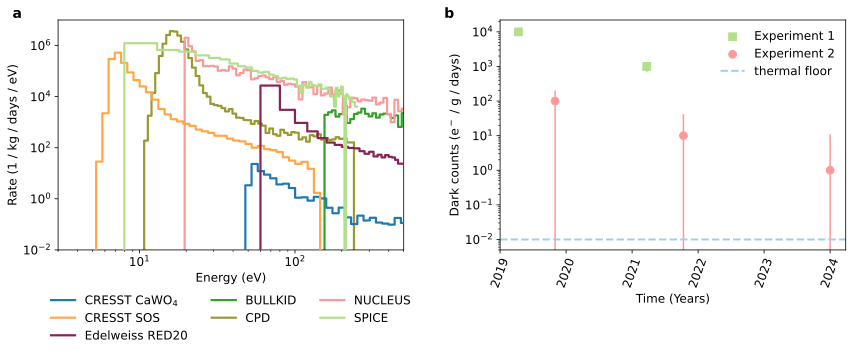

In [24]:
fig, ax = plt.subplots(1, 2, dpi=300, figsize=(12,5))

# ---------------------------------------------
# a: close-to-final version of panel (a)
# ---------------------------------------------

# experiments



ax[0].step(data['cresst_CaWO4']['bc'], data['cresst_CaWO4']['hist'], where='mid', 
            linewidth=2.2, label=r'CRESST CaWO$_4$', zorder=6,color=colors[1])  # if no fill use linewith 2.2

#ax[0].step(data['cresst_Al2O3']['bc'], data['cresst_Al2O3']['hist'], where='mid', 
#            linewidth=2.2, label=r'CRESST Al$_2$O$_3$', zorder=6,color=colors[1])  # if no fill use linewith 2.2

ax[0].step(data['cresst_SOS']['bc'], data['cresst_SOS']['hist'], where='mid', 
            linewidth=2.2, label='CRESST SOS', zorder=6, color=colors[2])  # if no fill use linewith 2.2

ax[0].step(data['Edelweiss']['bc'], data['Edelweiss']['hist'], where='mid', 
            linewidth=2.2, label='Edelweiss RED20', zorder=6,color=colors[6])  # if no fill use linewith 2.2

ax[0].step(data['bc'], data['bullkid']['hist'], where='mid', 
            linewidth=2.2, label='BULLKID', zorder=2,color=colors[4])

ax[0].step(data['bc'], data['CPD']['hist'], where='mid', 
            linewidth=2.2, label='CPD', zorder=2, color=colors[7])

ax[0].step(data['bc'], data['nucleus']['hist'], where='mid', 
            linewidth=2.2, label='NUCLEUS', zorder=2,color=colors[5])

ax[0].step(data['TESSERACT']['bc'], data['TESSERACT']['hist'], where='mid', 
            linewidth=2.2, label='SPICE', zorder=6,color=colors[3])  # if no fill use linewith 2.2



# dm spectrum
#ax[0].plot(data['grid'], data['dmrate'], color='black', linewidth=2.2, linestyle='dashed', zorder=20, 
#           label='DM recoils')
#ax[0].text(5, .1, "$m$ = {:.2} GeV,\n$\sigma$ = {:.2} pb,\nsilicon target".format(dm_mass, crosssection))

# specs
fig.text(0.02, 0.97, 'a', size=14, weight='bold')
ax[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(3, 500)
ax[0].set_ylim(1e-2, 1e7)
ax[0].set_ylabel('Rate (1 / kg / days / eV)')
ax[0].set_xlabel('Energy (eV)')

# ---------------------------------------------
# b
# ---------------------------------------------

# experiments

ax[1].scatter(data_e['exp1']['date'], data_e['exp1']['rate'],
              color=colors[3], s=60, marker='s', label='Experiment 1', )
ax[1].errorbar(data_e['exp1']['date'], data_e['exp1']['rate'], 
               yerr=data_e['exp1']['uncertainty'], #fmt="o", 
               color=colors[3],
              )

ax[1].scatter(data_e['exp2']['date'], data_e['exp2']['rate'],
              color=colors[3], s=60, marker='s')
ax[1].errorbar(data_e['exp2']['date'], data_e['exp2']['rate'], 
               yerr=data_e['exp2']['uncertainty'], #fmt="o",  
               color=colors[3],
              )

ax[1].scatter(data_e['exp3']['date'], data_e['exp3']['rate'],
              color=colors[5], s=60, label='Experiment 2')
ax[1].errorbar(data_e['exp3']['date'], data_e['exp3']['rate'], 
               yerr=data_e['exp3']['uncertainty'], #fmt="o", 
               color=colors[5],
              )

ax[1].scatter(data_e['exp4']['date'], data_e['exp4']['rate'],
              color=colors[5], s=60)
ax[1].errorbar(data_e['exp4']['date'], data_e['exp4']['rate'], 
               yerr=data_e['exp4']['uncertainty'], #fmt="o", 
               color=colors[5],
              )

ax[1].scatter(data_e['exp5']['date'], data_e['exp5']['rate'],
              color=colors[5], s=60)
ax[1].errorbar(data_e['exp5']['date'], data_e['exp5']['rate'], 
               yerr=data_e['exp5']['uncertainty'], #fmt="o", 
               color=colors[5],
              )

# thermal limits

ax[1].axhline(data_e['thermal'], color=colors[0], linewidth=2, linestyle='dashed',
              label='thermal floor')

# specs
fig.text(0.52, 0.97, 'b', size=14, weight='bold')
ax[1].legend(frameon=False, loc='upper right')
ax[1].set_xscale('linear')
ax[1].set_yscale('log')
# ax[1].set_xlim(0, 600)
# ax[1].set_ylim(1e-1, 1e5)
ax[1].set_ylabel('Dark counts (e$^-$ / g / days)')
ax[1].set_xlabel('Time (Years)')
ax[1].set_xticks([0, 360, 720, 1080, 1440, 1800],
                 labels=["2019", "2020", "2021", "2022", "2023", "2024"],
                 rotation=70)

# ---------------------------------------------
# globals 
# ---------------------------------------------


plt.tight_layout()
plt.savefig('plots/fig2.png')
plt.show()